1. Define assets, initial cash, weight per asset, benchmark, download starting date and live portfolio start date.
2. We download the values.
3. We assign the initial investment and weight per asset
4. We prepare the initial shares per asset depending on the assigned weight
5. We perform the rebalancing engine (daily, monthly or yearly) read in the intro.
6. We calculate the metrics and values ​​of the portfolio and variation in weights
7. We visualize
8. We carry out the study in pyfolio for the strategy. We need to localize timezones for this example.
<hr>

In [1]:
# pip install pyfolio
# pip install nbformat

In [2]:
# Selecting libraries
import nbformat
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
warnings.filterwarnings("ignore")

c:\Users\josh\AppData\Local\Programs\Python\Python312\Lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


| Variable                  | Description                     |
|---------------------------|---------------------------------|
| Date                     | Date of the data points        |
| PX_LAST                   | Last Price                      |
| PX_BID                    | Bid Price                       |
| LAST_PRICE                | Last Trade/Last Price           |
| PX_ASK                    | Ask Price                       |
| PX_MID                    | Mid Price                       |
| CHG_PCT_1D                | Price Change 1 Day Percent      |
| CUR_MKT_CAP               | Current Market Cap              |
| PX_CLOSE_1D               | Closing Price 1 Day Ago         |

In [3]:
equity = pd.read_csv('./Input/SPY_Data.csv')
highyield = pd.read_csv('./Input/highyield_Data.csv')
safebond = pd.read_csv('./Input/safebond_Data.csv')

equity = equity.drop(equity.index[:4])
equity = equity.reset_index(drop=True)  # Reset the index before setting column names
equity.columns = equity.iloc[0]  # Set the first row as column names
equity = equity.drop(equity.index[0])  # Drop the first row
equity = equity.reset_index(drop=True)  # Reset the index again

# Convert columns to float
equity['LAST_PRICE'] = pd.to_numeric(equity['LAST_PRICE'], errors='coerce')
# equity['CHG_PCT_1D'] = pd.to_numeric(equity['CHG_PCT_1D'], errors='coerce')
equity['CUR_MKT_CAP'] = pd.to_numeric(equity['CUR_MKT_CAP'], errors='coerce')

# Drop the specified columns
equity = equity.drop(columns=['PX_LAST', 'PX_BID', 'PX_ASK', 'PX_MID', 'PX_CLOSE_1D', 'CHG_PCT_1D'])
equity['Dates'] = pd.to_datetime(equity['Dates'])
# equity = equity.set_index('Dates')
# equity


highyield = highyield.drop(highyield.index[:4])
highyield = highyield.reset_index(drop=True)  # Reset the index before setting column names
highyield.columns = highyield.iloc[0]  # Set the first row as column names
highyield = highyield.drop(highyield.index[0])  # Drop the first row
highyield = highyield.reset_index(drop=True)  # Reset the index again

# Convert columns to float
highyield['LAST_PRICE'] = pd.to_numeric(highyield['LAST_PRICE'], errors='coerce')
# highyield['CHG_PCT_1D'] = pd.to_numeric(highyield['CHG_PCT_1D'], errors='coerce')
highyield['CUR_MKT_CAP'] = pd.to_numeric(highyield['CUR_MKT_CAP'], errors='coerce')

# Drop the specified columns
highyield = highyield.drop(columns=['PX_LAST', 'PX_BID', 'PX_ASK', 'PX_MID', 'PX_CLOSE_1D', 'CHG_PCT_1D'])
highyield['Dates'] = pd.to_datetime(highyield['Dates'])
# highyield = highyield.set_index('Dates')
# highyield


safebond = safebond.drop(safebond.index[:4])
safebond = safebond.reset_index(drop=True)  # Reset the index before setting column names
safebond.columns = safebond.iloc[0]  # Set the first row as column names
safebond = safebond.drop(safebond.index[0])  # Drop the first row
safebond = safebond.reset_index(drop=True)  # Reset the index again

safebond['LAST_PRICE'] = pd.to_numeric(safebond['LAST_PRICE'], errors='coerce')
# safebond['CHG_PCT_1D'] = pd.to_numeric(safebond['CHG_PCT_1D'], errors='coerce')
safebond['CUR_MKT_CAP'] = pd.to_numeric(safebond['CUR_MKT_CAP'], errors='coerce')

# Drop the specified columns
safebond = safebond.drop(columns=['PX_LAST', 'PX_BID', 'PX_ASK', 'PX_MID', 'PX_CLOSE_1D', 'CHG_PCT_1D'])
safebond['Dates'] = pd.to_datetime(safebond['Dates'])
# safebond = safebond.set_index('Dates')
# safebonddd

# Find the first non-NaN date for equity
equity_first_valid_date = equity['LAST_PRICE'].first_valid_index()
highyield_first_valid_date = highyield['LAST_PRICE'].first_valid_index()
safebond_first_valid_date = safebond['LAST_PRICE'].first_valid_index()

latest_first_valid_date = max(equity_first_valid_date, highyield_first_valid_date, safebond_first_valid_date)

equity = equity[equity.index >= highyield_first_valid_date]
equity = equity.reset_index(drop=True)
highyield = highyield[highyield.index >= highyield_first_valid_date]
highyield = highyield.reset_index(drop=True)
safebond = safebond[safebond.index >= highyield_first_valid_date]
safebond = safebond.reset_index(drop=True)

### General Index Exploriation

In [4]:
equity['DailyReturn'] = equity['LAST_PRICE'].pct_change()
highyield['DailyReturn'] = highyield['LAST_PRICE'].pct_change()
safebond['DailyReturn'] = safebond['LAST_PRICE'].pct_change()
# Calculate cumulative returns
equity['cumret'] = (1 + equity['DailyReturn']).cumprod() - 1
highyield['cumret'] = (1 + highyield['DailyReturn']).cumprod() - 1
safebond['cumret'] = (1 + safebond['DailyReturn']).cumprod() - 1

# Calculate log returns
equity['LogReturn'] = np.log(equity['LAST_PRICE'] / equity['LAST_PRICE'].shift(1))
highyield['LogReturn'] = np.log(highyield['LAST_PRICE'] / highyield['LAST_PRICE'].shift(1))
safebond['LogReturn'] = np.log(safebond['LAST_PRICE'] / safebond['LAST_PRICE'].shift(1))

In [5]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
# Get the default colors
default_green = default_colors[2]
default_orange = default_colors[1]
default_blue = default_colors[0]

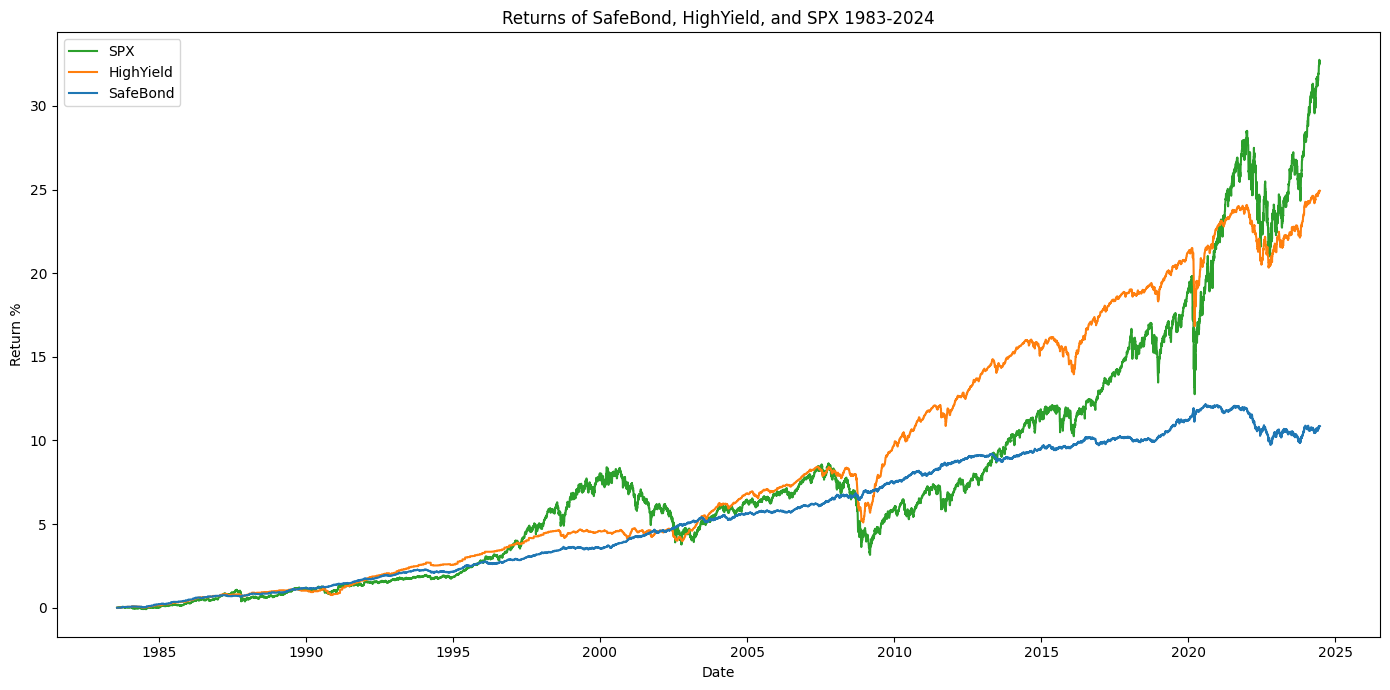

In [6]:
# Plotting
plt.figure(figsize=(14, 7))

plt.plot(equity['Dates'], equity['cumret'], label='SPX', color = default_green)
plt.plot(highyield['Dates'], highyield['cumret'], label='HighYield', color = default_orange)
plt.plot(safebond['Dates'], safebond['cumret'], label='SafeBond', color = default_blue)

plt.title('Returns of SafeBond, HighYield, and SPX 1983-2024')
plt.xlabel('Date')
plt.ylabel('Return %')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
window_size = 30
equity['Volatility'] = equity['DailyReturn'].rolling(window=window_size).std() * np.sqrt(252)
safebond['Volatility'] = safebond['DailyReturn'].rolling(window=window_size).std() * np.sqrt(252)
highyield['Volatility'] = highyield['DailyReturn'].rolling(window=window_size).std() * np.sqrt(252)

# Find the highest volatility and corresponding date for each ETF
equity_max_volatility = equity['Volatility'].max()
equity_max_volatility_date = equity['Dates'][equity['Volatility'].idxmax()]

highyield_max_volatility = highyield['Volatility'].max()
highyield_max_volatility_date = highyield['Dates'][highyield['Volatility'].idxmax()]

safebond_max_volatility = safebond['Volatility'].max()
safebond_max_volatility_date = safebond['Dates'][safebond['Volatility'].idxmax()]

print(f"Equity Max Volatility: {equity_max_volatility:.2%}   Date: {equity_max_volatility_date.strftime('%Y-%m-%d')}")
print(f"HighYield Max Volatility: {highyield_max_volatility:.2%}   Date: {highyield_max_volatility_date.strftime('%Y-%m-%d')}")
print(f"SafeBond Max Volatility: {safebond_max_volatility:.2%}   Date: {safebond_max_volatility_date.strftime('%Y-%m-%d')}")

Equity Max Volatility: 80.46%   Date: 2020-04-06
HighYield Max Volatility: 35.49%   Date: 1991-03-28
SafeBond Max Volatility: 15.35%   Date: 1985-06-28


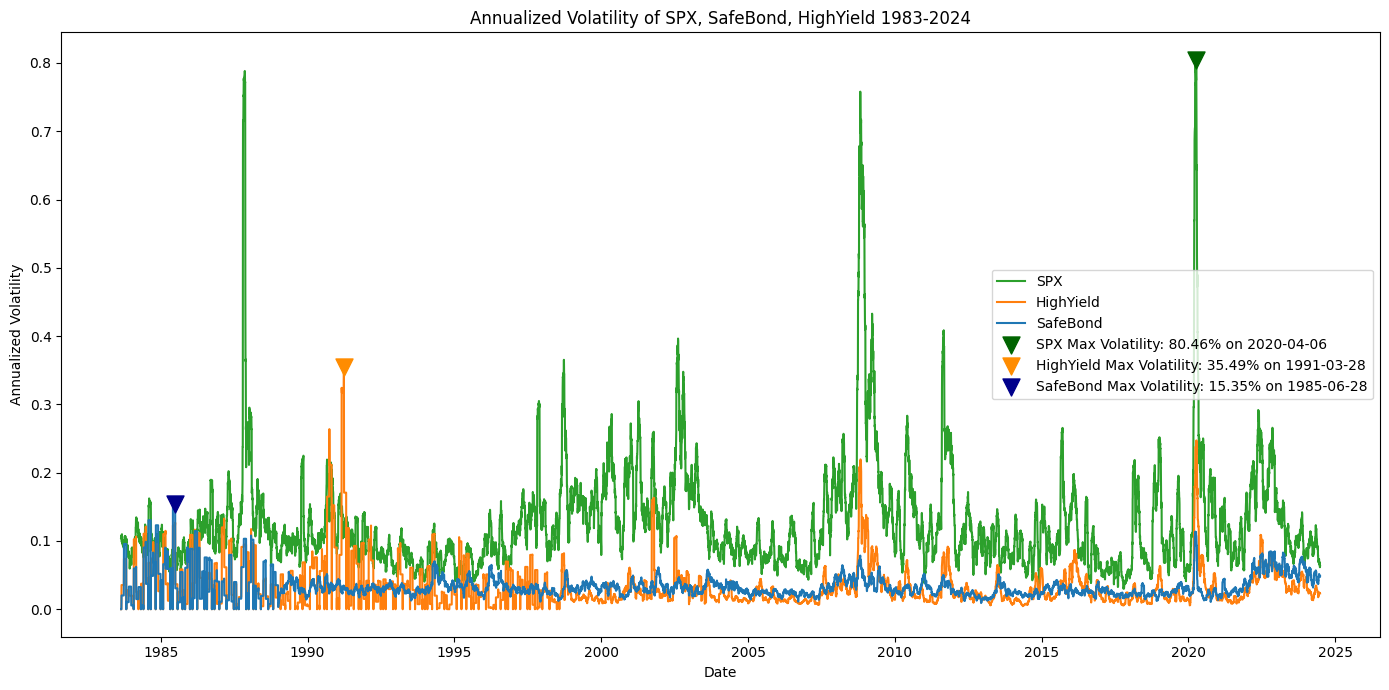

In [8]:
# Plotting the annualized volatility
plt.figure(figsize=(14, 7))

plt.plot(equity['Dates'], equity['Volatility'], label='SPX', color = default_green)
plt.plot(highyield['Dates'], highyield['Volatility'], label='HighYield', color = default_orange)
plt.plot(safebond['Dates'], safebond['Volatility'], label='SafeBond', color = default_blue)

# Add markers for the highest volatility points
plt.scatter(equity_max_volatility_date, equity_max_volatility, color='darkgreen', marker='v', s=150, zorder=5, label=f'SPX Max Volatility: {equity_max_volatility:.2%} on {equity_max_volatility_date.strftime("%Y-%m-%d")}')
plt.scatter(highyield_max_volatility_date, highyield_max_volatility, color='darkorange', marker='v', s=150, zorder=5, label=f'HighYield Max Volatility: {highyield_max_volatility:.2%} on {highyield_max_volatility_date.strftime("%Y-%m-%d")}')
plt.scatter(safebond_max_volatility_date, safebond_max_volatility, color='darkblue', marker='v', s=150, zorder=5, label=f'SafeBond Max Volatility: {safebond_max_volatility:.2%} on {safebond_max_volatility_date.strftime("%Y-%m-%d")}')

plt.title('Annualized Volatility of SPX, SafeBond, HighYield 1983-2024')
plt.xlabel('Date')
plt.ylabel('Annualized Volatility')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Calculate the cumulative maximum of the adjusted close prices
equity['CumulativeMax'] = equity['LAST_PRICE'].cummax()
highyield['CumulativeMax'] = highyield['LAST_PRICE'].cummax()
safebond['CumulativeMax'] = safebond['LAST_PRICE'].cummax()

# Calculate the drawdown
equity['Drawdown'] = (equity['LAST_PRICE'] - equity['CumulativeMax']) / equity['CumulativeMax']
highyield['Drawdown'] = (highyield['LAST_PRICE'] - highyield['CumulativeMax']) / highyield['CumulativeMax']
safebond['Drawdown'] = (safebond['LAST_PRICE'] - safebond['CumulativeMax']) / safebond['CumulativeMax']

# Calculate the maximum drawdown
equity_max_drawdown = equity['Drawdown'].min()
highyield_max_drawdown = highyield['Drawdown'].min()
safebond_max_drawdown = safebond['Drawdown'].min()

equity_max_drawdown_date = equity['Dates'][equity['Drawdown'].idxmin()].strftime('%Y-%m-%d')
highyield_max_drawdown_date = highyield['Dates'][highyield['Drawdown'].idxmin()].strftime('%Y-%m-%d')
safebond_max_drawdown_date = safebond['Dates'][safebond['Drawdown'].idxmin()].strftime('%Y-%m-%d')

print(f"Equity Max Drawdown: {equity_max_drawdown:.2%}   Date: {equity_max_drawdown_date}")
print(f"HighYield Max Drawdown: {highyield_max_drawdown:.2%}   Date: {highyield_max_drawdown_date}")
print(f"SafeBond Max Drawdown: {safebond_max_drawdown:.2%}   Date: {safebond_max_drawdown_date}")

Equity Max Drawdown: -56.78%   Date: 2009-03-09
HighYield Max Drawdown: -35.34%   Date: 2008-12-12
SafeBond Max Drawdown: -18.41%   Date: 2022-10-24


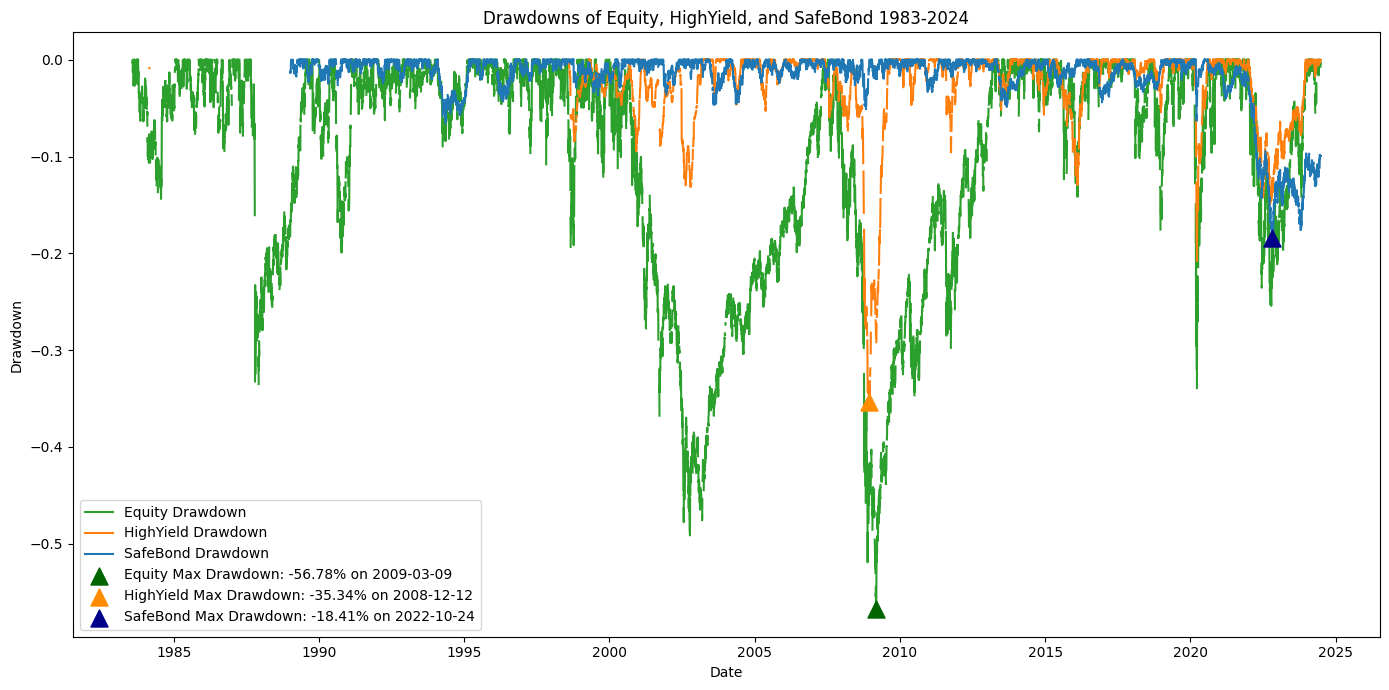

In [10]:
# Plotting the drawdowns
plt.figure(figsize=(14, 7))

equity_max_drawdown_date = pd.to_datetime(equity['Dates'][equity['Drawdown'].idxmin()])
highyield_max_drawdown_date = pd.to_datetime(highyield['Dates'][highyield['Drawdown'].idxmin()])
safebond_max_drawdown_date = pd.to_datetime(safebond['Dates'][safebond['Drawdown'].idxmin()])

plt.plot(equity['Dates'], equity['Drawdown'], label='Equity Drawdown', color = default_green)
plt.plot(highyield['Dates'], highyield['Drawdown'], label='HighYield Drawdown', color = default_orange)
plt.plot(safebond['Dates'], safebond['Drawdown'], label='SafeBond Drawdown', color = default_blue)

# Add distinguishable markers for max drawdowns
plt.scatter(equity_max_drawdown_date, equity['Drawdown'].min(), color='darkgreen', marker='^', s=150, zorder=5, label=f'Equity Max Drawdown: {equity["Drawdown"].min():.2%} on {equity_max_drawdown_date.strftime("%Y-%m-%d")}')
plt.scatter(highyield_max_drawdown_date, highyield['Drawdown'].min(), color='darkorange', marker='^', s=150, zorder=5, label=f'HighYield Max Drawdown: {highyield["Drawdown"].min():.2%} on {highyield_max_drawdown_date.strftime("%Y-%m-%d")}')
plt.scatter(safebond_max_drawdown_date, safebond['Drawdown'].min(), color='darkblue', marker='^', s=150, zorder=5, label=f'SafeBond Max Drawdown: {safebond["Drawdown"].min():.2%} on {safebond_max_drawdown_date.strftime("%Y-%m-%d")}')

plt.title('Drawdowns of Equity, HighYield, and SafeBond 1983-2024')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
equity.to_csv('./Cleaned_Data/SPX.csv', index=False)
highyield.to_csv('./Cleaned_Data/highyield.csv', index=False)
safebond.to_csv('./Cleaned_Data/safebond.csv', index=False)